## 1. IMPORT CÁC THƯ VIỆN

In [1]:
# -*- coding: utf-8 -*-
"""
Dog Breed Classification using Transfer Learning
Chuyển đổi từ .ipynb sang .py
"""

# === 1. IMPORT CÁC THƯ VIỆN ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
from zipfile import ZipFile
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
import albumentations as A

# Tắt các cảnh báo
warnings.filterwarnings('ignore')
# Tự động tối ưu hóa pipeline
AUTO = tf.data.experimental.AUTOTUNE

## 2. GIẢI NÉN DỮ LIỆU

In [2]:
data_path = 'dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()
    print('Bộ dữ liệu đã được trích xuất.')

Bộ dữ liệu đã được trích xuất.


## 3. ĐỌC VÀ PHÂN TÍCH DỮ LIỆU (EDA)

5 dòng đầu của dữ liệu:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
Trực quan hóa phân bố các giống chó...


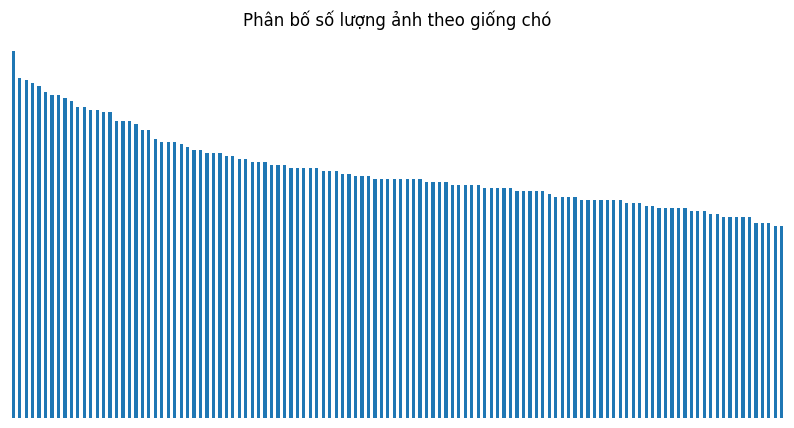

Thêm cột 'filepath':
                                 id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                     filepath  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  train/001cdf01b096e06d78e9e5112d419397.jpg  
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg  
Hiển thị 12 ảnh ngẫu nhiên...


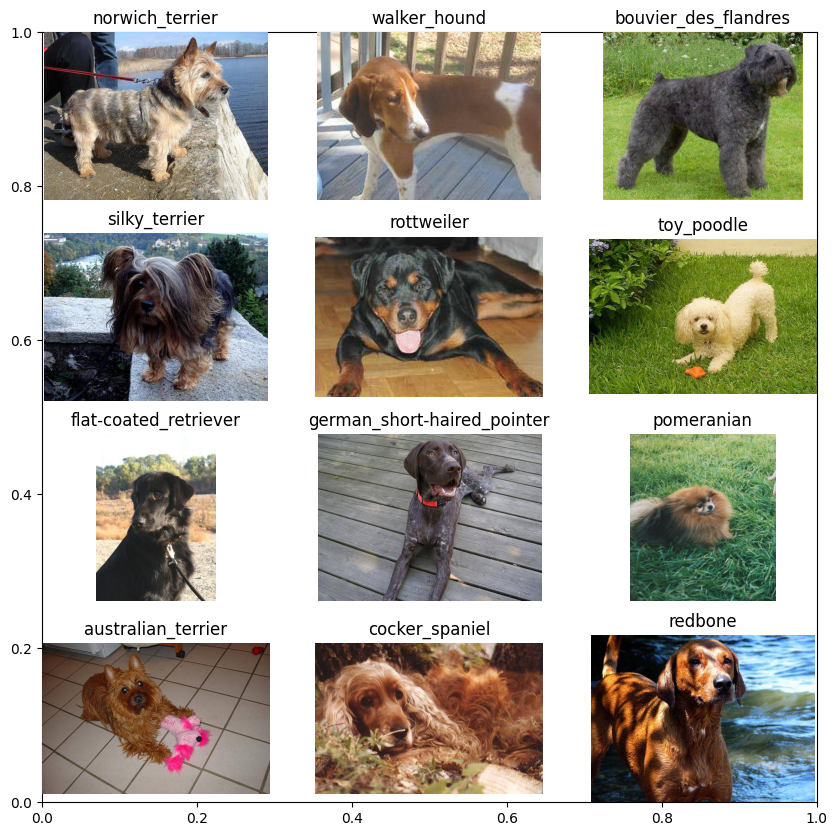

In [3]:
df = pd.read_csv('labels.csv')
print("5 dòng đầu của dữ liệu:")
print(df.head())

# Trực quan hóa sự mất cân bằng dữ liệu
print("Trực quan hóa phân bố các giống chó...")
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.title("Phân bố số lượng ảnh theo giống chó")
plt.axis('off')
plt.show()

# Tạo đường dẫn file hoàn chỉnh
df['filepath'] = 'train/' + df['id'] + '.jpg'
print("Thêm cột 'filepath':")
print(df.head())

# Trực quan hóa một vài ảnh ngẫu nhiên
print("Hiển thị 12 ảnh ngẫu nhiên...")
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    # Chuyển đổi BGR (OpenCV) sang RGB (Matplotlib) để hiển thị đúng màu
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

## 4. TIỀN XỬ LÝ DỮ LIỆU

In [4]:
# Mã hóa nhãn (Label Encoding)
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
print("Dữ liệu sau khi mã hóa nhãn:")
print(df.head())

# Tách features (X) và target (Y)
features = df['filepath']
target = df['breed']

# Chia tập train và validation
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.15,
                                                  random_state=10)

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Validation: {X_val.shape}")

Dữ liệu sau khi mã hóa nhãn:
                                 id  breed  \
0  000bec180eb18c7604dcecc8fe0dba07     19   
1  001513dfcb2ffafc82cccf4d8bbaba97     37   
2  001cdf01b096e06d78e9e5112d419397     85   
3  00214f311d5d2247d5dfe4fe24b2303d     15   
4  0021f9ceb3235effd7fcde7f7538ed62     49   

                                     filepath  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  train/001cdf01b096e06d78e9e5112d419397.jpg  
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg  
Kích thước tập Train: (8688,)
Kích thước tập Validation: (1534,)


## 5. TĂNG CƯỜNG DỮ LIỆU (DATA AUGMENTATION)

Hiển thị ví dụ về augmentation...


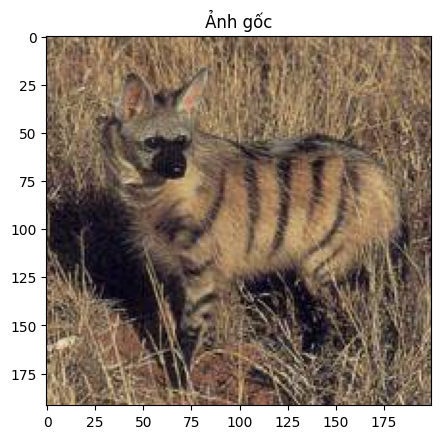

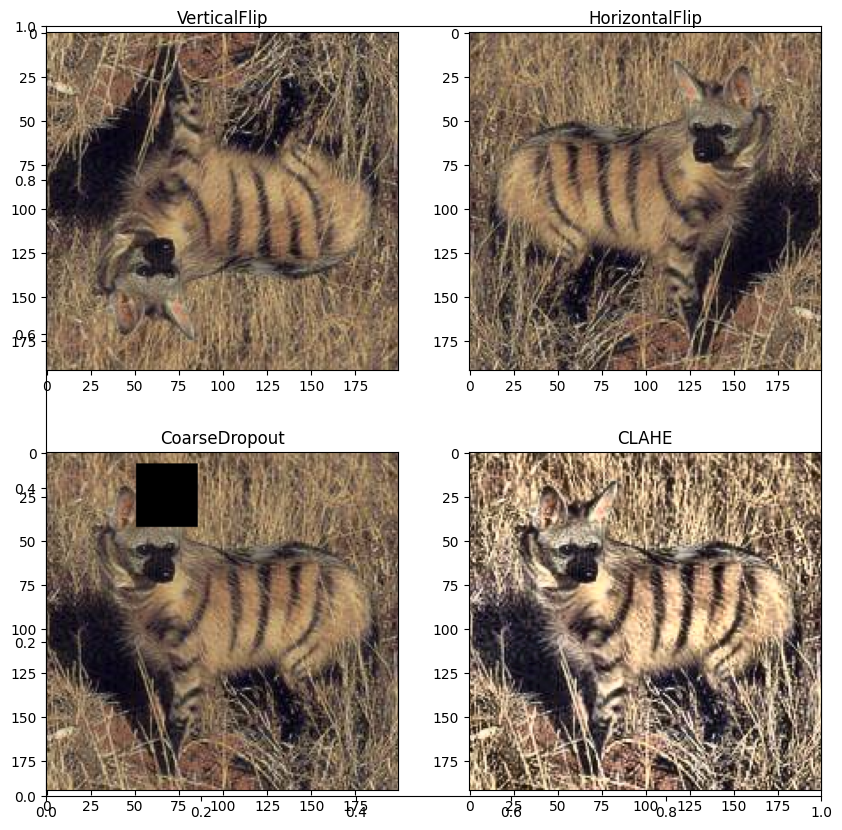

In [5]:
# Định nghĩa các phép biến đổi
transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

# Hiển thị ví dụ về augmentation
print("Hiển thị ví dụ về augmentation...")
img_example_path = 'train/00792e341f3c6eb33663e415d0715370.jpg'
img = cv2.imread(img_example_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Ảnh gốc")
plt.show()

augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i + 1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
    plt.title(aug.__class__.__name__)
plt.show()

## 6. XÂY DỰNG PIPELINE DỮ LIỆU (tf.data)

In [6]:
# Hàm wrapper cho augmentation của Albumentations
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']
    return aug_img

# Hàm xử lý và tăng cường (chỉ cho tập train)
@tf.function
def process_data(img, label):
    # Dùng tf.numpy_function để chạy code Python (Albumentations) trong pipeline của TensorFlow
    aug_img = tf.numpy_function(aug_fn, [img], Tout=tf.float32)
    
    # === SỬA LỖI VALUEERROR TẠI ĐÂY ===
    # "Báo" cho TensorFlow biết shape chính xác của ảnh sau khi xử lý
    aug_img.set_shape([128, 128, 3]) 
    # =================================
    
    return aug_img, label

# Hàm đọc, giải mã và chuẩn hóa ảnh
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3) # Đảm bảo ảnh có 3 kênh màu
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label is None:
        return img
    
    return img, tf.one_hot(indices=label, depth=120, dtype=tf.float32)

# Tạo pipeline cho tập Train
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(process_data, num_parallel_calls=AUTO) # Áp dụng augmentation
    .batch(32)
    .prefetch(AUTO)
)

# Tạo pipeline cho tập Validation
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO) # Không augmentation
    .batch(32)
    .prefetch(AUTO)
)

# Kiểm tra shape của một batch
print("Kiểm tra shape của 1 batch:")
for img, label in train_ds.take(1):
    print(img.shape, label.shape)

Kiểm tra shape của 1 batch:
(32, 128, 128, 3) (32, 120)


## 7. XÂY DỰNG MÔ HÌNH (TRANSFER LEARNING)

In [7]:
# Tải mô hình InceptionV3 (không bao gồm lớp fully-connected ở trên cùng)
pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

# Đóng băng các lớp đã huấn luyện
for layer in pre_trained_model.layers:
    layer.trainable = False

# Lấy đầu ra từ một lớp ở giữa (mixed7)
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

# Xây dựng phần "đầu" (head) phân loại tùy chỉnh
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

# Ghép mô hình gốc và "đầu" tùy chỉnh
model = keras.Model(pre_trained_model.input, output)

# Biên dịch mô hình
model.compile(
    optimizer='adam',
    # Lớp cuối dùng 'softmax' nên 'from_logits' phải là False
    loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
    metrics=[tf.keras.metrics.AUC(name='auc')] # Đặt tên cho metric
)

model.summary()

Last layer output shape:  (None, 6, 6, 768)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 16,152,088 (61.62 MB)

 Trainable params: 7,175,800 (27.37 MB)

 Non-trainable params: 8,976,288 (34.24 MB)

## 8. ĐỊNH NGHĨA CALLBACKS

In [8]:
# Callback tự định nghĩa để dừng sớm
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
            print('\nValidation AUC đã đạt > 0.99, dừng huấn luyện.')
            self.model.stop_training = True

# Early Stopping
es = EarlyStopping(patience=3,
                   monitor='val_auc',
                   restore_best_weights=True,
                   mode='max')

# Giảm Learning Rate
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

## 9. HUẤN LUYỆN MÔ HÌNH

In [9]:
print("Bắt đầu huấn luyện mô hình...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Tăng số epochs để mô hình hội tụ
    verbose=1,
    callbacks=[es, lr, myCallback()]
)

print("Huấn luyện hoàn tất.")

Bắt đầu huấn luyện mô hình...
Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 74s 253ms/step - auc: 0.7797 - loss: 4.0378 - val_auc: 0.9191 - val_loss: 2.7669 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 58s 215ms/step - auc: 0.9162 - loss: 2.8853 - val_auc: 0.9454 - val_loss: 2.3376 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - auc: 0.9421 - loss: 2.3904 - val_auc: 0.9461 - val_loss: 2.2606 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - auc: 0.9541 - loss: 2.1122 - val_auc: 0.9373 - val_loss: 2.2737 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - auc: 0.9623 - loss: 1.8667 - val_auc: 0.9381 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 56s 205ms/step - auc: 0.9671 - loss: 1.6820 - val_auc: 0.9340 - val_loss: 2.2423 - learning_rate: 0.0010
Huấn luyện hoàn tất.


## 10. ĐÁNH GIÁ VÀ TRỰC QUAN HÓA KẾT QUẢ

Trực quan hóa kết quả huấn luyện...


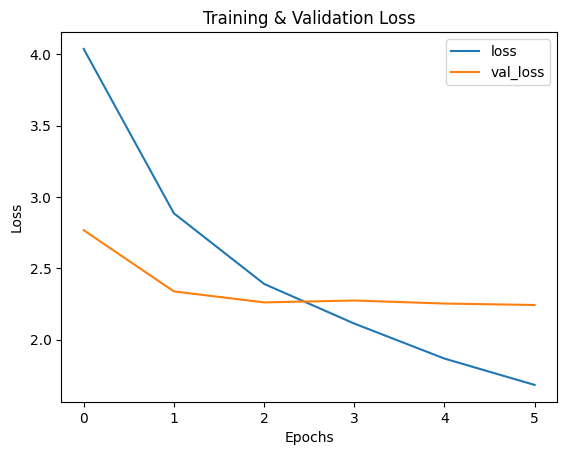

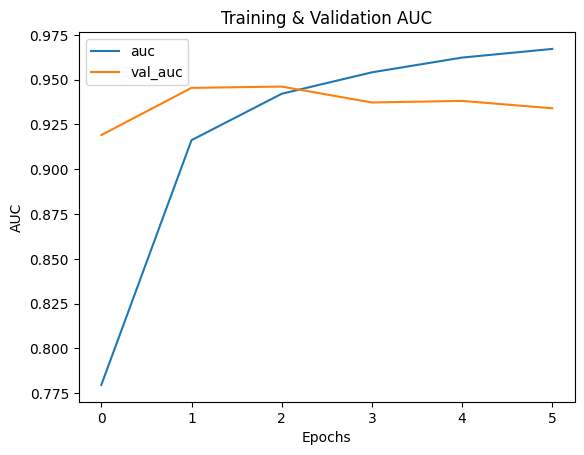

Script hoàn tất.


In [10]:
print("Trực quan hóa kết quả huấn luyện...")
history_df = pd.DataFrame(history.history)

# Vẽ đồ thị Loss
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Vẽ đồ thị AUC
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.title("Training & Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.show()

print("Script hoàn tất.")

## 11. DỰ ĐOÁN VỚI ẢNH MỚI



--- BẮT ĐẦU PHẦN DỰ ĐOÁN ẢNH MỚI ---
Đang dự đoán ảnh: C:\Users\hhoan\Desktop\computer vision\test\0a01f3b0c6d250c08785716c562e2d4d.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

--- KẾT QUẢ DỰ ĐOÁN ---
File: C:\Users\hhoan\Desktop\computer vision\test\0a01f3b0c6d250c08785716c562e2d4d.jpg
Giống chó: pembroke
Độ tự tin: 61.54%


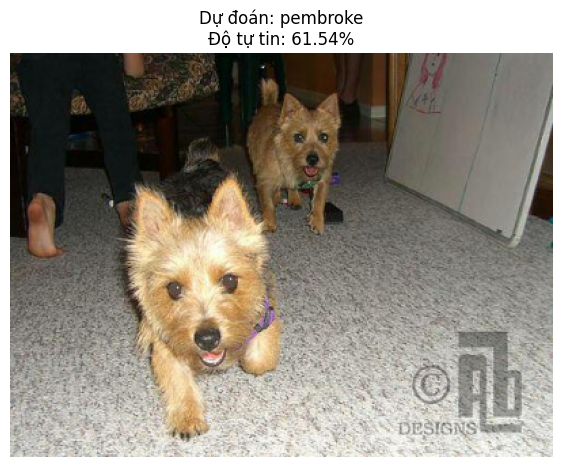

--- KẾT THÚC PHẦN DỰ ĐOÁN ---


In [ ]:
import os 

print("\n\n--- BẮT ĐẦU PHẦN DỰ ĐOÁN ẢNH MỚI ---")

# --- HÀM HỖ TRỢ DỰ ĐOÁN ---
def preprocess_for_prediction(filepath):
    """
    Đọc, giải mã, resize (128x128) và chuẩn hóa một ảnh duy nhất.
    Trả về một batch (1, 128, 128, 3) sẵn sàng cho model.predict()
    và một ảnh (đã resize) để hiển thị.
    """
    # 1. Đọc file
    img = tf.io.read_file(filepath)
    
    # 2. Giải mã (decode)
    # Dùng try-except để bắt lỗi nếu file không phải là ảnh hợp lệ
    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError:
        print(f"Lỗi: Không thể giải mã file {filepath}. File có thể bị hỏng hoặc không phải là JPEG.")
        return None, None

    # 3. Resize ảnh để hiển thị (kích thước lớn hơn cho đẹp)
    img_display = tf.image.resize(img, [400, 400], preserve_aspect_ratio=True)
    img_display = tf.cast(img_display, tf.uint8) # Matplotlib cần kiểu uint8 để hiển thị

    # 4. Resize ảnh về kích thước model mong đợi (128, 128)
    img_resized = tf.image.resize(img, [128, 128])
    
    # 5. Chuẩn hóa (scale 0-1) giống như lúc train
    img_normalized = tf.cast(img_resized, tf.float32) / 255.0
    
    # 6. Thêm chiều batch (model.predict mong đợi input có shape (None, 128, 128, 3))
    img_batch = tf.expand_dims(img_normalized, axis=0) # Shape trở thành (1, 128, 128, 3)
    
    return img_batch, img_display


new_image_path = 'C:\\Users\\hhoan\\Desktop\\computer vision\\R.jpg'


# Kiểm tra xem file có tồn tại không
if not os.path.exists(new_image_path):
    print(f"LỖI: Không tìm thấy file tại '{new_image_path}'")
    print("Vui lòng kiểm tra lại biến 'new_image_path' và thử lại.")
else:
    # 1. Tiền xử lý ảnh
    img_batch, img_to_display = preprocess_for_prediction(new_image_path)
    
    # Chỉ tiếp tục nếu ảnh được xử lý thành công
    if img_batch is not None:
        try:
            # 2. Thực hiện dự đoán
            print(f"Đang dự đoán ảnh: {new_image_path}...")
            # model.predict() trả về một mảng các xác suất
            prediction_probabilities = model.predict(img_batch)
            
            # 3. Xử lý kết quả dự đoán
            # Lấy kết quả cho ảnh đầu tiên (và duy nhất) trong batch
            probabilities = prediction_probabilities[0] 
            
            # Tìm chỉ số (index) của lớp có xác suất cao nhất
            predicted_index = np.argmax(probabilities)
            
            # Lấy xác suất (độ tự tin) của dự đoán đó
            confidence = probabilities[predicted_index]
            
            # Dùng LabelEncoder (le) đã fit ở mục 4 để lấy tên giống chó
            # le.inverse_transform mong đợi một mảng, nên ta truyền [predicted_index]
            predicted_breed_name = le.inverse_transform([predicted_index])[0]
            
            # 4. In kết quả ra console
            print(f"\n--- KẾT QUẢ DỰ ĐOÁN ---")
            print(f"File: {new_image_path}")
            print(f"Giống chó: {predicted_breed_name}")
            print(f"Độ tự tin: {confidence * 100:.2f}%")
            
            # 5. Hiển thị ảnh với kết quả dự đoán
            plt.figure(figsize=(7, 8))
            plt.imshow(img_to_display)
            title_text = f"Dự đoán: {predicted_breed_name}\nĐộ tự tin: {confidence * 100:.2f}%"
            plt.title(title_text)
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Đã xảy ra lỗi trong quá trình dự đoán: {e}")

print("--- KẾT THÚC PHẦN DỰ ĐOÁN ---")